In [1]:
import numpy as np
import pandas as pd
import datetime
from sklearn.cluster import DBSCAN
from mta_data_extract import turnstile_data_extractor

In [30]:
class turnstile_data_extractor_test():
    def __init__(self):
        self.stations = pickle.load(open("stations.p","rb"))
        
    def _convert_start_date(self,date):
        date = datetime.datetime.strptime(date, "%y%m%d")
        idx = (date.weekday() + 1) % 7
        sat = date - datetime.timedelta(7+idx-6)
        return sat
    
    def _get_dates(self, start_date, weeks=1):
        start_date = self._convert_start_date(start_date)
        dates = []
        dates.append(start_date.strftime("%y%m%d"))
        for x in range(1,weeks):
            next_date = (start_date - datetime.timedelta(weeks=x)).strftime("%y%m%d")
            dates.append(next_date)
        return sorted(dates)

    def _get_files(self, start_date, weeks):
        files = []
        dates = self._get_dates(start_date, weeks)
        for d in dates:
            files.append(f'http://web.mta.info/developers/data/nyct/turnstile/turnstile_{d}.txt')
        return files

    def _extract_mta_data(self,start_date, weeks=1):
        """Extracts weekly data files from MTA for range of weeks.
        To do: Need to hardcode columns so they stay consistent 
        for model input"""
        file_locs = self._get_files(start_date, weeks)
        df = pd.DataFrame()
        errs = []
        for file in file_locs:
            try:
                df_ = pd.read_csv(file)
            except:
                errs.append(file)
                df_ = pd.read_csv(file, 
                                engine='python', 
                                sep=',', 
                                #lineterminator='\n'
                                )
            df = df.append(df_)
        df = df.reset_index(drop=True)
        df.columns = [x.strip() for x in df.columns]
        df['TIME'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'])
        df = df.sort_values(['STATION','C/A','UNIT','SCP','TIME'])
        df = df[df['STATION'].isin(self.stations)]
        df = df[df['TIME'].dt.minute==0]
        return df
    
    def _anomaly_replacement(self, df):
        df_out = df.copy()
        for x in ['ent','ex']:
            # Find way to not fillna until after dbscan; may be filling with outliers sometimes
            # Step 1: Label where nan are located
            # Step 2: Fill na with mean value
            # Step 4: dbscan 
            # Step 5: revert nan's back to nan
            # Step 5: outliers set to nan
            df[[x]] = df[[x]].fillna(method='bfill').fillna(method='ffill')
            _df = df[[x]]
            #previously used eps 220
            eps = int(_df[x].quantile(0.99)*1.5)
            if eps < 220:
                eps = 220
            dbscan = DBSCAN(eps=eps, 
                            min_samples=9)
            dbscan.fit(_df)
            outliers = np.argwhere(dbscan.labels_ == -1).flatten()
            _df.iloc[outliers,:] = np.nan
            _df = _df.fillna(method='bfill').fillna(method='ffill')
            df_out[x] = _df
        return df_out
    
    def _resample_counts(self,df):
        """Resamples data to hourly; raw data is pulled every four 
        hours or so at different times for different stations"""
        df2 = df.copy()
        df2['diff'] = df['TIME'].diff()/np.timedelta64(1,'h')
        df2 = df2.set_index('TIME')
        df2['ent'] = df2['ent']/df2['diff']
        df2['ex'] = df2['ex']/df2['diff']
        return df2[['ent','ex']].resample('H').mean().bfill().reset_index()
    
    def get_entries_exits(self, df, replace_anomalies=False):
        """Returns dfs for entires and exits by station"""
        df['ent'] = df[['ENTRIES',
                        'STATION',
                        'UNIT',
                        'SCP',
                        'C/A']].groupby(['STATION','UNIT','SCP','C/A']).diff()
        df['ex'] = df[['EXITS',
                    'STATION',
                    'UNIT',
                    'SCP',
                    'C/A']].groupby(['STATION','UNIT','SCP','C/A']).diff()
        df['ent'].loc[df['ent']< 0] = np.nan
        df['ex'].loc[df['ex']< 0] = np.nan
        df = df[['TIME','STATION','ent','ex']]
        
        #consider moving anomaly detection to here, prior to resample
        # REMOVE ALL ROWS HAVING INDEX TIME NOT ON THE TOP OF THE HOUR
        # ex: df[df.index.minute==0]
        df1 = df[['TIME','STATION','ent','ex']].groupby(['STATION','TIME'])\
                                            .sum()\
                                            .reset_index()
        #Anomaly detection, prior to resample
        if replace_anomalies == True:                        
            df1 = df1[['TIME','STATION','ent','ex']].groupby('STATION')\
                                                    .apply(self._anomaly_replacement)

        df1 = df1[['TIME','STATION','ent','ex']].groupby('STATION')\
                                                .apply(self._resample_counts)\
                                                .reset_index()
        
        df_out_ent = df1.pivot(index='TIME',
                            columns='STATION',
                            values='ent')

        df_out_ex = df1.pivot(index='TIME',
                            columns='STATION',
                            values='ex')
        return df_out_ent.ffill().bfill(), df_out_ex.ffill().bfill()

    def get_data(self, start_date, weeks=1, replace_anomalies=False):
        df = self._extract_mta_data(start_date, weeks=weeks)
        df_ent, df_ex = self.get_entries_exits(df, replace_anomalies)
        df_ent.columns = [x+"_ent" for x in df_ent.columns]
        df_ex.columns = [x+"_ex" for x in df_ex.columns]
        df_out = pd.concat([df_ent,df_ex], axis=1)
        return df_out[sorted(df_out.columns)]  

In [31]:
start_date = "221231"
weeks = 2
replace_anomalies = True

In [32]:
de = turnstile_data_extractor_test()

In [33]:
df = de.get_data(start_date=start_date,
                 weeks=weeks,
                 replace_anomalies=True)
df.shape

/var/folders/td/4jttxk_j59ngw4ck3xdp25th0000gn/T/ipykernel_11523/4089781660.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_)
/var/folders/td/4jttxk_j59ngw4ck3xdp25th0000gn/T/ipykernel_11523/4089781660.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_)
/var/folders/td/4jttxk_j59ngw4ck3xdp25th0000gn/T/ipykernel_11523/4089781660.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ent'].loc[df['ent']< 0] = np.nan
/var/folders/td/4jttxk_j59ngw4ck3xdp25th0000gn/T/ipykernel_11523/4089781660.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

(336, 738)

In [34]:
df.max().sort_values(ascending=False)

GRD CNTRL-42 ST_ex    20579.000000
HARRISON_ex           19807.636136
34 ST-PENN STA_ex     16503.000000
FULTON ST_ex          14218.000000
CANAL ST_ex           13753.000000
                          ...     
14TH STREET_ex            5.333333
NEWARK BM BW_ex           2.754016
BROAD CHANNEL_ex          2.250000
TOMPKINSVILLE_ex          0.250000
ST. GEORGE_ex             0.250000
Length: 738, dtype: float64

In [35]:
df.max().sort_values(ascending=False).tail(10)

BEACH 105 ST_ent      13.500000
AQUEDUCT RACETR_ex    10.250000
NEWARK C_ex            8.680733
RIT-ROOSEVELT_ex       7.500000
RIT-MANHATTAN_ex       6.750000
14TH STREET_ex         5.333333
NEWARK BM BW_ex        2.754016
BROAD CHANNEL_ex       2.250000
TOMPKINSVILLE_ex       0.250000
ST. GEORGE_ex          0.250000
dtype: float64

In [8]:
to_drop = ['PATH NEW WTC_ex','PATH NEW WTC_ent','JOURNAL SQUARE_ent','JOURNAL SQUARE_ex',
           'NEWARK HW BMEBE_ent','NEWARK HW BMEBE_ex','PATH WTC 2_ent','PATH WTC 2_ex','PAVONIA/NEWPORT_ent',
           'PAVONIA/NEWPORT_ex']

In [9]:
df = df.drop(to_drop, axis=1)

In [36]:
df.max().sort_values(ascending=False)

GRD CNTRL-42 ST_ex    20579.000000
HARRISON_ex           19807.636136
34 ST-PENN STA_ex     16503.000000
FULTON ST_ex          14218.000000
CANAL ST_ex           13753.000000
                          ...     
14TH STREET_ex            5.333333
NEWARK BM BW_ex           2.754016
BROAD CHANNEL_ex          2.250000
TOMPKINSVILLE_ex          0.250000
ST. GEORGE_ex             0.250000
Length: 738, dtype: float64

<AxesSubplot: xlabel='TIME'>

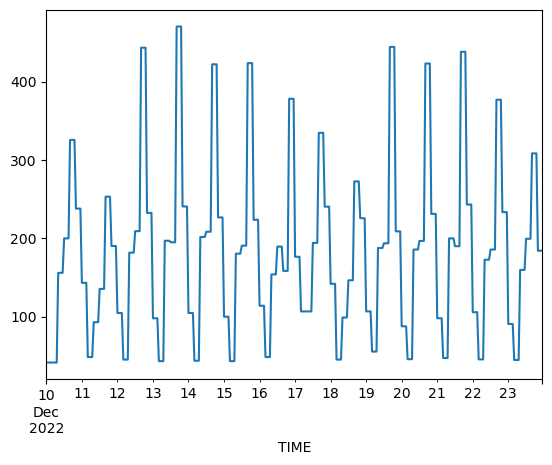

In [37]:
df['BURNSIDE AV_ex'].plot()

<AxesSubplot: xlabel='TIME'>

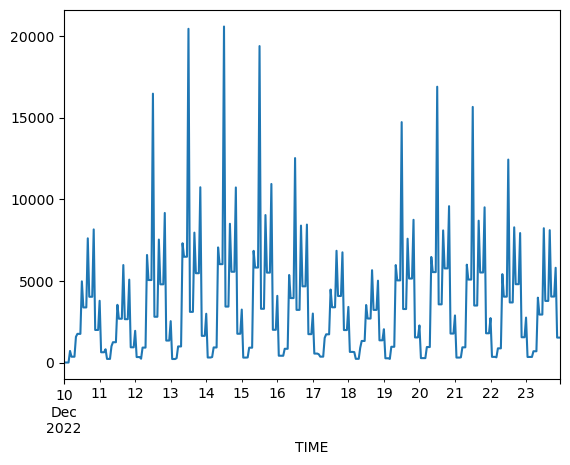

In [38]:
df['GRD CNTRL-42 ST_ex'].plot()

In [13]:
df.head()

,1 AV_ent,1 AV_ex,103 ST-CORONA_ent,103 ST-CORONA_ex,103 ST_ent,103 ST_ex,104 ST_ent,104 ST_ex,110 ST_ent,110 ST_ex,...,WOODLAWN_ent,WOODLAWN_ex,WORLD TRADE CTR_ent,WORLD TRADE CTR_ex,WTC-CORTLANDT_ent,WTC-CORTLANDT_ex,YORK ST_ent,YORK ST_ex,ZEREGA AV_ent,ZEREGA AV_ex
TIME,,,,,,,,,,,,,,,,,,,,,
2022-12-10 00:00:00,27.75,154.75,284.5,135.25,34.75,225.0,44.5,11.5,41.25,82.25,...,45.0,15.5,20.25,45.75,15.0,75.25,16.75,56.5,1.25,27.75
2022-12-10 01:00:00,27.75,154.75,284.5,135.25,34.75,225.0,44.5,11.5,41.25,82.25,...,45.0,15.5,20.25,45.75,15.0,75.25,16.75,56.5,1.25,27.75
2022-12-10 02:00:00,27.75,154.75,284.5,135.25,34.75,225.0,44.5,11.5,41.25,82.25,...,45.0,15.5,20.25,45.75,15.0,75.25,16.75,56.5,1.25,27.75
2022-12-10 03:00:00,27.75,154.75,284.5,135.25,34.75,225.0,44.5,11.5,41.25,82.25,...,45.0,15.5,20.25,45.75,15.0,75.25,16.75,56.5,1.25,27.75
2022-12-10 04:00:00,27.75,154.75,284.5,135.25,34.75,225.0,44.5,11.5,41.25,82.25,...,45.0,15.5,20.25,45.75,15.0,75.25,16.75,56.5,1.25,27.75


<AxesSubplot: xlabel='TIME'>

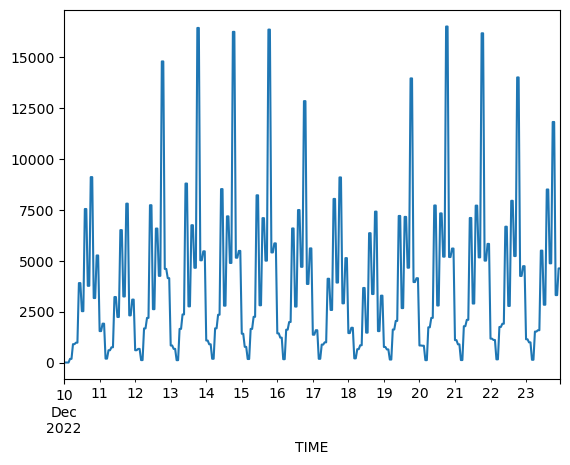

In [17]:
df['34 ST-PENN STA_ex'].plot()

In [18]:
cols = [x for x in df.columns]

In [29]:
stations = set(x.split("_")[0] for x in df.columns)
pickle.dump(stations, open("stations.p","wb"))

In [21]:
import pickle
pickle.dump(cols, open("entries_exits_list.p","wb"))

In [ ]:
df1 = de._extract_mta_data(start_date, weeks=1)

In [ ]:
df1.shape

In [ ]:
df_ent, df_ex = turnstile_data_extractor_test().get_entries_exits(df1)

In [ ]:
df_ent['BURNSIDE AV'].plot()